In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import gsw as sw

# Path containing python functions
path = ['/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/']

sys.path.append(path[0])
from functions import c2salinity,p2depth,dm2d,rad2deg,O2freshtosal,range_check,correctDR,findProfiles

# Explore Glider Processing Steps

A notebook to test functions and get comfortable with the toolbox capabilities
- Do some basic processing
- Plot some things
- Showcase functions and capabilities

### Checking out the dead reckoning correction for Slocum glider based on `x_dr_state`

In [2]:
# Glider data set from Unit 334 collected in Placentia Bay in 2022
df = pd.read_csv('glider_334_data.csv')
print(list(df.columns.values))

# convert from DDMM.MM to DD.DD
for col in ['lat', 'lon', 'gps_lat', 'gps_lon']:
    if(col in df.keys()):
        df[col] = dm2d(df[col])

['time', 'lat', 'lon', 'dr_state', 'gps_lat', 'gps_lon', 'ctd_temp', 'ctd_cond', 'ctd_pressure', 'oxy_oxygen']


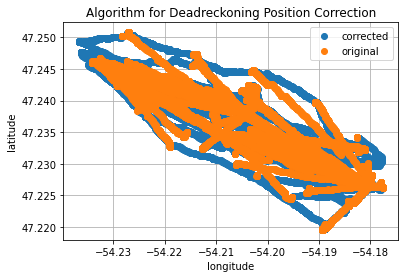

In [3]:
# Run the dead reckoning correction code
df['lon_corrected'],df['lat_corrected'] = correctDR(df['lon'],df['lat'],df['time'],df['dr_state'],df['gps_lon'],df['gps_lat'])

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(df['lon_corrected'],df['lat_corrected'],'o',label='corrected')
ax.plot(df['lon'],df['lat'],'o',label='original')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Algorithm for Deadreckoning Position Correction')
ax.grid()
ax.legend()
fig.savefig("DRtest.png")
plt.show()


### Calculate some parameters and do some basic corrections

- First do linear interpolation/filling of gaps 
- 



In [10]:
# Interpolate and fill gaps linearly but preserving nans in the beginning and end (crude method to get what we want)
df = df.fillna(method='ffill') + (df.fillna(method='bfill') * 0)

df['depth'] = p2depth(df['ctd_pressure']*10)


#sw.sigma0(31.4,4.5)


24.761872887818754

### Split Profiles
The findProfiles function splits the glider depth,time data to profiles and profile direction, which is useful for further post-processing

[1.66731440e+09 1.66731440e+09 1.66731440e+09 1.66731441e+09
 1.66731441e+09 1.66731441e+09 1.66731441e+09 1.66731441e+09
 1.66731441e+09 1.66731441e+09 1.66731441e+09 1.66731441e+09
 1.66731441e+09 1.66731441e+09 1.66731441e+09 1.66731442e+09
 1.66731442e+09 1.66731442e+09 1.66731442e+09 1.66731442e+09
 1.66731442e+09 1.66731442e+09 1.66731442e+09 1.66731442e+09
 1.66731442e+09 1.66731442e+09 1.66731442e+09 1.66731442e+09
 1.66731443e+09 1.66731443e+09 1.66731443e+09 1.66731443e+09
 1.66731443e+09 1.66731443e+09 1.66731443e+09 1.66731443e+09
 1.66731443e+09 1.66731443e+09 1.66731443e+09 1.66731443e+09
 1.66731444e+09 1.66731444e+09 1.66731444e+09 1.66731444e+09
 1.66731444e+09 1.66731444e+09 1.66731444e+09 1.66731444e+09
 1.66731444e+09 1.66731444e+09 1.66731444e+09 1.66731444e+09
 1.66731445e+09 1.66731445e+09 1.66731445e+09 1.66731445e+09
 1.66731445e+09 1.66731445e+09 1.66731445e+09 1.66731445e+09]
[ 5.98856089  5.98856089  5.98856089  6.40497778  6.40497778  6.78173521
  6.7817352

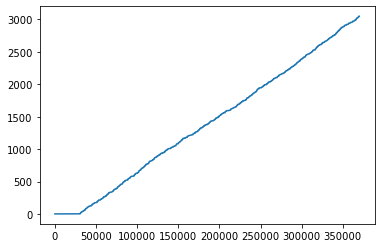

In [97]:
# initialize test data
#depth = np.array([0.5,0.7,1,2,3,4,5,6,7,8,9,10,9,10,9,8,7,6,5,4,3,2,1.5,0.9,0])
#stamp = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

stamp=np.array(df['time'])
print(stamp[100:160])
depth=np.array(df['depth'])
print(depth[100:160])

profile_index,profile_direction=findProfiles(stamp,depth,stall=0,shake=20)
plt.plot(profile_index)


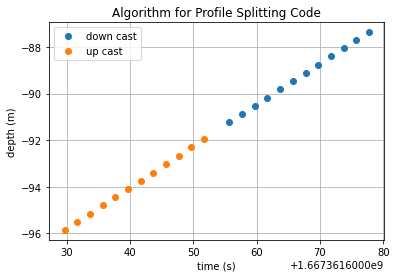

In [98]:



fig, ax = plt.subplots()
idx_down = np.argwhere(profile_index==120)
idx_up = np.argwhere(profile_index==119)

ax.plot(stamp[idx_down],-depth[idx_down],'o',label='down cast')
ax.plot(stamp[idx_up],-depth[idx_up],'o',label='up cast')
ax.set(xlabel='time (s)', ylabel='depth (m)',
       title='Algorithm for Profile Splitting Code')
ax.grid()
ax.legend()
plt.show()

In [7]:
"""

options_list = {
        "length": 0,
        "period": 0,
        "inversion": 0,
        "interrupt": 0,
        "stall": 0,
        "shake": 0,
}

# Inputs are 1D Vectors
    depth= depth.flatten()
    stamp= stamp.flatten()

    # LOGIC BEGINS

    valid_index  = np.argwhere(np.logical_not(np.logical_or(np.isnan(depth),np.isnan(stamp)))).flatten()
    valid_index  = valid_index.astype(int)
    sdy = np.sign( np.diff( depth[valid_index],n=1,axis=0))
    depth_peak =  np.ones(np.size(valid_index), dtype=bool)
    depth_peak[1:len(depth_peak)-1,] = np.diff(sdy,n=1,axis=0) !=0
    depth_peak_index = valid_index[depth_peak]
    sgmt_frst = stamp[depth_peak_index[0:len(depth_peak_index)-1,]]
    sgmt_last = stamp[depth_peak_index[1:,]]
    sgmt_strt = depth[depth_peak_index[0:len(depth_peak_index)-1,]]
    sgmt_fnsh = depth[depth_peak_index[1:,]]
    sgmt_sinc = sgmt_last - sgmt_frst
    sgmt_vinc = sgmt_fnsh - sgmt_strt
    sgmt_vdir = np.sign(sgmt_vinc)

    #print(sgmt_vdir,sgmt_vinc,sgmt_sinc,sgmt_fnsh)

    cast_sgmt_valid = np.logical_not(np.logical_or(np.abs(sgmt_vinc) <= options_list["stall"],sgmt_sinc <= options_list["shake"]))
    cast_sgmt_index = np.argwhere(cast_sgmt_valid).flatten()
    cast_sgmt_lapse = sgmt_frst[cast_sgmt_index[1:]] - sgmt_last[cast_sgmt_index[0:len(cast_sgmt_index)-1]]
    cast_sgmt_space = -np.abs(sgmt_vdir[cast_sgmt_index[0:len(cast_sgmt_index)-1]] * (sgmt_strt[cast_sgmt_index[1:]] - sgmt_fnsh[cast_sgmt_index[0:len(cast_sgmt_index)-1]] ))
    cast_sgmt_dirch = np.diff(sgmt_vdir[cast_sgmt_index],n=1,axis=0)
    cast_sgmt_bound = np.logical_not((cast_sgmt_dirch[:,] == 0) & (cast_sgmt_lapse[:,] <= options_list["interrupt"]) & (cast_sgmt_space <= options_list["inversion"]))
    cast_sgmt_head_valid = np.ones(np.size(cast_sgmt_index), dtype=bool)
    cast_sgmt_tail_valid = np.ones(np.size(cast_sgmt_index), dtype=bool)
    cast_sgmt_head_valid[1:,] = cast_sgmt_bound
    cast_sgmt_tail_valid[0:len(cast_sgmt_tail_valid)-1,] = cast_sgmt_bound

    cast_head_index = depth_peak_index[cast_sgmt_index[cast_sgmt_head_valid]]
    cast_tail_index = depth_peak_index[cast_sgmt_index[cast_sgmt_tail_valid] + 1]
    cast_length = np.abs(depth[cast_tail_index] - depth[cast_head_index])
    cast_period = stamp[cast_tail_index] - stamp[cast_head_index];

    cast_valid = np.logical_not(np.logical_or(cast_length <= options_list["length"],cast_period <= options_list["period"]))
    cast_head = np.zeros(np.size(depth))
    cast_tail = np.zeros(np.size(depth))
    cast_head[cast_head_index[cast_valid] + 1] = 0.5
    cast_tail[cast_tail_index[cast_valid]] = 0.5

    # initialize output np arrays
    profile_index = 0.5 + np.cumsum(cast_head + cast_tail)
    profile_direction = np.empty((len(depth,)))
    profile_direction[:]= np.nan

    for i in range(len(valid_index)-1):
        i_start = valid_index[i]
        i_end = valid_index[i+1]
        #print(i,i_start,i_end)
        profile_direction[i_start:i_end]=sdy[i]


#print(profile_index,profile_direction)

"""

'\n\noptions_list = {\n        "length": 0,\n        "period": 0,\n        "inversion": 0,\n        "interrupt": 0,\n        "stall": 0,\n        "shake": 0,\n}\n\n# Inputs are 1D Vectors\n    depth= depth.flatten()\n    stamp= stamp.flatten()\n\n    # LOGIC BEGINS\n\n    valid_index  = np.argwhere(np.logical_not(np.logical_or(np.isnan(depth),np.isnan(stamp)))).flatten()\n    valid_index  = valid_index.astype(int)\n    sdy = np.sign( np.diff( depth[valid_index],n=1,axis=0))\n    depth_peak =  np.ones(np.size(valid_index), dtype=bool)\n    depth_peak[1:len(depth_peak)-1,] = np.diff(sdy,n=1,axis=0) !=0\n    depth_peak_index = valid_index[depth_peak]\n    sgmt_frst = stamp[depth_peak_index[0:len(depth_peak_index)-1,]]\n    sgmt_last = stamp[depth_peak_index[1:,]]\n    sgmt_strt = depth[depth_peak_index[0:len(depth_peak_index)-1,]]\n    sgmt_fnsh = depth[depth_peak_index[1:,]]\n    sgmt_sinc = sgmt_last - sgmt_frst\n    sgmt_vinc = sgmt_fnsh - sgmt_strt\n    sgmt_vdir = np.sign(sgmt_vinc)\